# Titanic Survival Prediction using R

# Introduction

Using `randomForest` to create a model predicting survival on the Titanic.

* Feature engineering
* Missing value imputation
* Prediction!

## Load and check data

In [1]:
#install packages
install.packages("ggplot2")
install.packages("ggthemes")
install.packages("scales")
install.packages("dplyr")
install.packages("mice")
install.packages("randomForest")
# Load packages
library('ggplot2') # visualization
library('ggthemes') # visualization
library('scales') # visualization
library('dplyr') # data manipulation
library('mice') # imputation
library('randomForest') # classification algorithm

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in install.packages("dplyr"):
“installation of package ‘dplyr’ had non-zero exit status”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘randomForest’ is not available for this version of R
‘randomForest’ version 4.7-1 is in the repositories but depends on R (>= 4.1.0)

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”

Attaching package: ‘dplyr’


The following objects are ma

Now that our packages are loaded, let's read in and take a peek at the data.

In [2]:
train <- read.csv('train.csv', stringsAsFactors = F)
test  <- read.csv('test.csv', stringsAsFactors = F)

In [3]:
full  <- bind_rows(train, test) # bind training & test data

In [4]:
# check data
str(full)

'data.frame':	1309 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : chr  "male" "female" "female" "female" ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : chr  "S" "C" "S" "S" ...


Variable Name | Description
--------------|-------------
Survived      | Survived (1) or died (0)
Pclass        | Passenger's class
Name          | Passenger's name
Sex           | Passenger's sex
Age           | Passenger's age
SibSp         | Number of siblings/spouses aboard
Parch         | Number of parents/children aboard
Ticket        | Ticket number
Fare          | Fare
Cabin         | Cabin
Embarked      | Port of embarkation

In [5]:
# Grab title from passenger names
full$Title <- gsub('(.*, )|(\\..*)', '', full$Name)

In [6]:
# Show title counts by sex
table(full$Sex, full$Title)

        
         Capt Col Don Dona  Dr Jonkheer Lady Major Master Miss Mlle Mme  Mr Mrs
  female    0   0   0    1   1        0    1     0      0  260    2   1   0 197
  male      1   4   1    0   7        1    0     2     61    0    0   0 757   0
        
          Ms Rev Sir the Countess
  female   2   0   0            1
  male     0   8   1            0

In [7]:
# Titles with very low cell counts to be combined to "rare" level
rare_title <- c('Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 
                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer')

In [8]:
# Also reassign mlle, ms, and mme accordingly
full$Title[full$Title == 'Mlle']        <- 'Miss' 
full$Title[full$Title == 'Ms']          <- 'Miss'
full$Title[full$Title == 'Mme']         <- 'Mrs' 
full$Title[full$Title %in% rare_title]  <- 'Rare Title'

In [9]:
# Show title counts by sex again
table(full$Sex, full$Title)

        
         Master Miss  Mr Mrs Rare Title
  female      0  264   0 198          4
  male       61    0 757   0         25

In [10]:
# Finally, grab surname from passenger name
full$Surname <- sapply(full$Name,  
                      function(x) strsplit(x, split = '[,.]')[[1]][1])

In [11]:
cat(paste('We have <b>', nlevels(factor(full$Surname)), '</b> unique surnames. I would be interested to infer ethnicity based on surname --- another time.'))

We have <b> 875 </b> unique surnames. I would be interested to infer ethnicity based on surname --- another time.

In [12]:
# Create a family size variable including the passenger themselves
full$Fsize <- full$SibSp + full$Parch + 1

In [13]:
# Create a family variable 
full$Family <- paste(full$Surname, full$Fsize, sep='_')

In [14]:
# Discretize family size
full$FsizeD[full$Fsize == 1] <- 'singleton'
full$FsizeD[full$Fsize < 5 & full$Fsize > 1] <- 'small'
full$FsizeD[full$Fsize > 4] <- 'large'

In [15]:
# This variable appears to have a lot of missing values
full$Cabin[1:28]

[1] ""            "C85"         ""            "C123"        ""           
 [6] ""            "E46"         ""            ""            ""           
[11] "G6"          "C103"        ""            ""            ""           
[16] ""            ""            ""            ""            ""           
[21] ""            "D56"         ""            "A6"          ""           
[26] ""            ""            "C23 C25 C27"

In [16]:
# The first character is the deck. For example:
strsplit(full$Cabin[2], NULL)[[1]]

[1] "C" "8" "5"

In [17]:
# Create a Deck variable. Get passenger deck A - F:
full$Deck<-factor(sapply(full$Cabin, function(x) strsplit(x, NULL)[[1]][1]))

In [18]:
# This variable appears to have a lot of missing values
full$Cabin[1:28]

[1] ""            "C85"         ""            "C123"        ""           
 [6] ""            "E46"         ""            ""            ""           
[11] "G6"          "C103"        ""            ""            ""           
[16] ""            ""            ""            ""            ""           
[21] ""            "D56"         ""            "A6"          ""           
[26] ""            ""            "C23 C25 C27"

In [19]:
# The first character is the deck. For example:
strsplit(full$Cabin[2], NULL)[[1]]

[1] "C" "8" "5"

In [20]:
# Create a Deck variable. Get passenger deck A - F:
full$Deck<-factor(sapply(full$Cabin, function(x) strsplit(x, NULL)[[1]][1]))

# Missingness



## Sensible value imputation

In [21]:
# Passengers 62 and 830 are missing Embarkment
full[c(62, 830), 'Embarked']

[1] "" ""

In [22]:
cat(paste('We will infer their values for **embarkment** based on present data that we can imagine may be relevant: **passenger class** and **fare**. We see that they paid<b> $', full[c(62, 830), 'Fare'][[1]][1], '</b>and<b> $', full[c(62, 830), 'Fare'][[1]][2], '</b>respectively and their classes are<b>', full[c(62, 830), 'Pclass'][[1]][1], '</b>and<b>', full[c(62, 830), 'Pclass'][[1]][2], '</b>. So from where did they embark?'))

We will infer their values for **embarkment** based on present data that we can imagine may be relevant: **passenger class** and **fare**. We see that they paid<b> $ 80 </b>and<b> $ NA </b>respectively and their classes are<b> 1 </b>and<b> NA </b>. So from where did they embark?

In [23]:
# Get rid of our missing passenger IDs
embark_fare <- full %>%
  filter(PassengerId != 62 & PassengerId != 830)

In [24]:
# Since their fare was $80 for 1st class, they most likely embarked from 'C'
full$Embarked[c(62, 830)] <- 'C'

In [25]:
# Show row 1044
full[1044, ]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,Fsize,Family,FsizeD,Deck
,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<fct>
1044,1044,NA,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NA,,S,Mr,Storey,1,Storey_1,singleton,NA


In [26]:
# Replace missing fare value with median fare for class/embarkment
full$Fare[1044] <- median(full[full$Pclass == '3' & full$Embarked == 'S', ]$Fare, na.rm = TRUE)

## Predictive imputation



In [27]:
sum(is.na(full$Age))

[1] 263

In [28]:
# Make variables factors into factors
factor_vars <- c('PassengerId','Pclass','Sex','Embarked',
                 'Title','Surname','Family','FsizeD')

full[factor_vars] <- lapply(full[factor_vars], function(x) as.factor(x))

In [29]:
# Set a random seed
set.seed(129)

In [30]:
# Perform mice imputation, excluding certain less-than-useful variables:
mice_mod <- mice(full[, !names(full) %in% c('PassengerId','Name','Ticket','Cabin','Family','Surname','Survived')], method='rf') 


 iter imp variable
  1   1  Age  Deck
  1   2  Age  Deck
  1   3  Age  Deck
  1   4  Age  Deck
  1   5  Age  Deck
  2   1  Age  Deck
  2   2  Age  Deck
  2   3  Age  Deck
  2   4  Age  Deck
  2   5  Age  Deck
  3   1  Age  Deck
  3   2  Age  Deck
  3   3  Age  Deck
  3   4  Age  Deck
  3   5  Age  Deck
  4   1  Age  Deck
  4   2  Age  Deck
  4   3  Age  Deck
  4   4  Age  Deck
  4   5  Age  Deck
  5   1  Age  Deck
  5   2  Age  Deck
  5   3  Age  Deck
  5   4  Age  Deck
  5   5  Age  Deck


Warning message:
“Number of logged events: 50”


In [31]:
# Save the complete output 
mice_output <- complete(mice_mod)

In [32]:
# Replace Age variable from the mice model.
full$Age <- mice_output$Age

In [33]:
# Show new number of missing Age values
sum(is.na(full$Age))

[1] 0

In [34]:
# Create the column child, and indicate whether child or adult
full$Child[full$Age < 18] <- 'Child'
full$Child[full$Age >= 18] <- 'Adult'

In [35]:
# Show counts
table(full$Child, full$Survived)

       
          0   1
  Adult 481 268
  Child  68  74

In [36]:
# Adding Mother variable
full$Mother <- 'Not Mother'
full$Mother[full$Sex == 'female' & full$Parch > 0 & full$Age > 18 & full$Title != 'Miss'] <- 'Mother'

In [37]:
# Show counts
table(full$Mother, full$Survived)

            
               0   1
  Mother      16  39
  Not Mother 533 303

In [38]:
# Finish by factorizing our two new factor variables
full$Child  <- factor(full$Child)
full$Mother <- factor(full$Mother)

# Prediction


## Split into training & test sets

Our first step is to split the data back into the original test and training sets.


In [39]:
# Split the data back into a train set and a test set
train <- full[1:891,]
test <- full[892:1309,]

## Building the model 

We then build our model using `randomForest` on the training set.

In [40]:
# Set a random seed
set.seed(754)

In [41]:
# Build the model (note: not all possible variables are used)
rf_model <- randomForest(factor(Survived) ~ Pclass + Sex + Age + SibSp + Parch + 
                                            Fare + Embarked + Title + 
                                            FsizeD + Child + Mother,
                                            data = train)

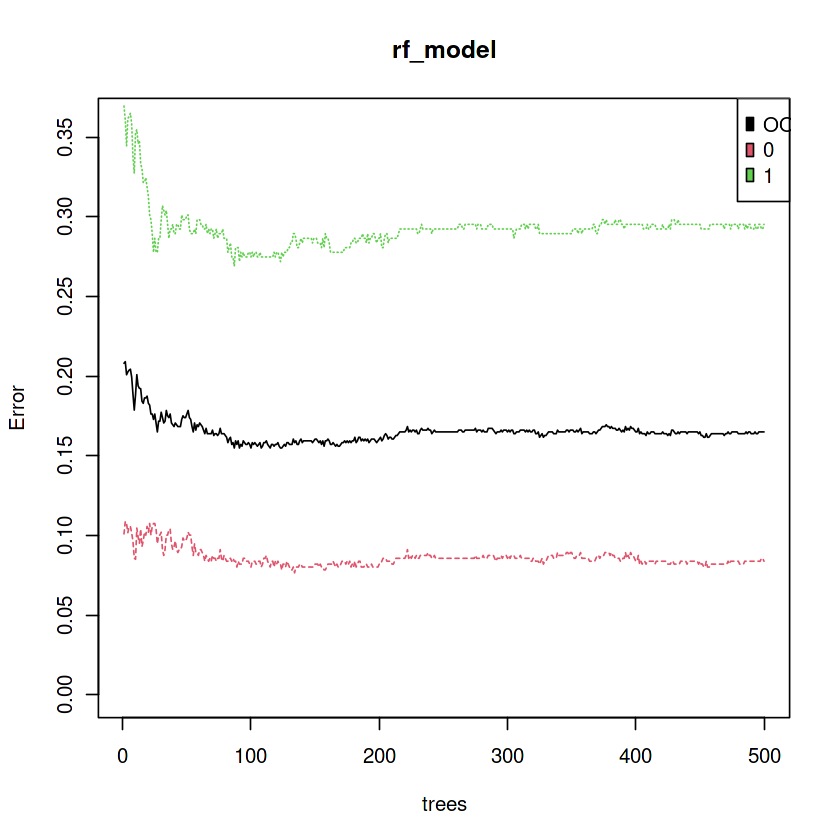

In [42]:
# Show model error
plot(rf_model, ylim=c(0,0.36))
legend('topright', colnames(rf_model$err.rate), col=1:3, fill=1:3)

## Variable importance


In [43]:
# Get importance
importance    <- importance(rf_model)
varImportance <- data.frame(Variables = row.names(importance), 
                            Importance = round(importance[ ,'MeanDecreaseGini'],2))


In [44]:
# Create a rank variable based on importance
rankImportance <- varImportance %>%
  mutate(Rank = paste0('#',dense_rank(desc(Importance))))

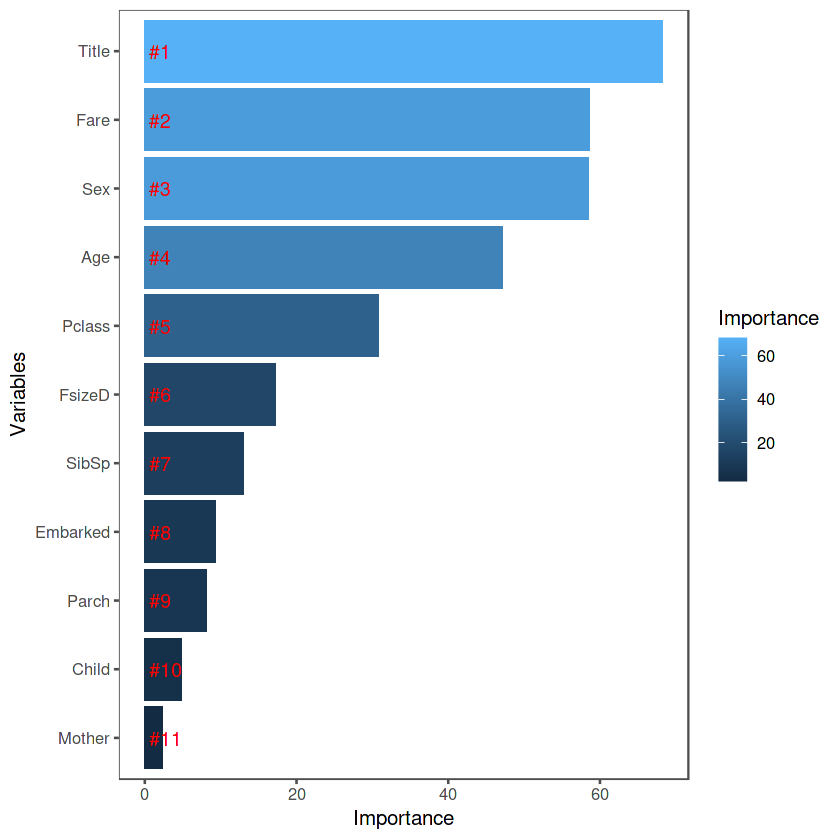

In [45]:
# Use ggplot2 to visualize the relative importance of variables
ggplot(rankImportance, aes(x = reorder(Variables, Importance), y = Importance, fill = Importance)) + geom_bar(stat='identity') + geom_text(aes(x = Variables, y = 0.5, label = Rank),hjust=0, vjust=0.55, size = 4, colour = 'red') +labs(x = 'Variables') +coord_flip() + theme_few()

## Prediction!

In [46]:
# Predict using the test set
prediction <- predict(rf_model, test)

In [47]:
# Save the solution to a dataframe with two columns: PassengerId and Survived (prediction)
solution <- data.frame(PassengerID = test$PassengerId, Survived = prediction)

In [48]:
# Write the solution to file
write.csv(solution, file = 'rf_mod_Solution.csv', row.names = F)